In [45]:
repo_directory = '/Users/iaincarmichael/Dropbox/Research/law/law-net/'

data_dir = '/Users/iaincarmichael/data/courtlistener/'

import numpy as np
import sys
import matplotlib.pyplot as plt


# graph package
import igraph as ig

# our code
sys.path.append(repo_directory + 'code/')
from setup_data_dir import setup_data_dir, make_subnetwork_directory
from pipeline.download_data import download_bulk_resource, download_master_edgelist, download_scdb
from helpful_functions import case_info

from stats.viz import *
from stats.dim_reduction import *
from stats.linear_model import *

sys.path.append(repo_directory + 'vertex_metrics_experiment/code/')
from rankscore_experiment_sort import *
from rankscore_experiment_LR import *
from make_tr_edge_df import *


# which network to download data for
network_name = 'scotus' # 'federal', 'ca1', etc


# some sub directories that get used
raw_dir = data_dir + 'raw/'
subnet_dir = data_dir + network_name + '/'
text_dir = subnet_dir + 'textfiles/'


# jupyter notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
G = ig.Graph.Read_GraphML(subnet_dir + network_name +'_network.graphml')

# compute metrics

In [208]:
%time d_pagerank = G.pagerank()

%time u_pagerank = G.as_undirected().pagerank()

In [209]:
%time d_betweenness = G.betweenness(directed=True)

%time u_betweenness = G.as_undirected().betweenness(directed=False)

In [212]:
%time d_closeness =  G.closeness(mode="IN", normalized=True)

%time u_closeness = G.as_undirected().closeness(normalized=True)

In [211]:
%time d_eigen = G.eigenvector_centrality()

%time u_eigen = G.as_undirected().eigenvector_centrality()

In [210]:
%time hubs = G.hub_score()

%time authorities = G.authority_score()

In [176]:
indegree = G.indegree()

outdegree = G.outdegree()

degree = G.degree()

In [225]:
df = pd.DataFrame(index=G.vs['name'])

df['year'] = G.vs['year']

df['indegree'] = indegree
df['outdegree'] = outdegree
df['degree'] = degree
df['d_pagerank'] = d_pagerank
df['u_pagerank'] = u_pagerank
df['d_betweenness'] = d_betweenness
df['u_betweenness'] = u_betweenness
df['d_closeness'] = d_closeness
df['u_closeness'] = u_closeness
df['d_eigen'] = d_eigen
df['u_eigen'] = u_eigen
df['hubs'] = hubs
df['authorities'] = authorities

all_metrics = ['indegree', 'outdegree', 'degree',
                'd_pagerank', 'u_pagerank',
                'd_betweenness', 'u_betweenness',
                'd_closeness', 'u_closeness',
                'd_eigen', 'u_eigen',
                'hubs', 'authorities']

# issue area


Procedural
- 1	Criminal Procedure
- 4	Due Process
- 6	Attorneys
- 9	Judicial Power

Substantive
- 2	Civil Rights
- 3	First Amendment
- 5	Privacy
- 7	Unions
- 8	Economic Activity
- 12	Federal Taxation
- 14	Private Action

Other
- 0 Missing
- 10	Federalism
- 11	Interstate Relations
- 13	Miscellaneous


## hypothesis
- betweeness/closeness favor procedural cases
- eivenvector metrics (eigenvector centrality, hubs, authorities) favor substantive cases

In [226]:
# map types to issues
type_to_issue = {'procedural': [1, 4, 6, 9],
                 'substantive': [2, 3, 5, 7, 8, 12, 14],
                 'other': [10, 11, 13, 0]}

# map issues to type
issue_to_type = {i: '' for i in range(13 + 1)}
for t in type_to_issue.keys():
    for i in type_to_issue[t]:
        issue_to_type[i] = t

In [227]:
# create type
G.vs['issueArea'] = [int(i) for i in G.vs['issueArea']]
G.vs['type'] = [issue_to_type[i] for i in G.vs['issueArea']]

# add to data frame
df['issueArea'] = G.vs['issueArea']
df['type'] = G.vs['type']

In [228]:
# get type subsets
df_sub = df[df['type'] == 'substantive']
df_pro = df[df['type'] == 'procedural']
df_oth = df[df['type'] == 'other']

print 'num substantive: %d' % df_sub.shape[0]
print 'num procedural: %d' % df_pro.shape[0]
print 'num other: %d' % df_oth.shape[0]

num substantive: 16891
num procedural: 9733
num other: 1261


In [221]:
df.to_csv(subnet_dir + 'issue_area/metrics.csv', index=True)

# compare metric vs. issue type

In [184]:
df.columns

Index([u'year', u'indegree', u'outdegree', u'degree', u'd_pagerank',
       u'u_pagerank', u'd_betweenness', u'u_betweenness', u'd_closeness',
       u'u_closeness', u'd_eigen', u'u_eigen', u'hubs', u'authorities',
       u'issueArea', u'type'],
      dtype='object')

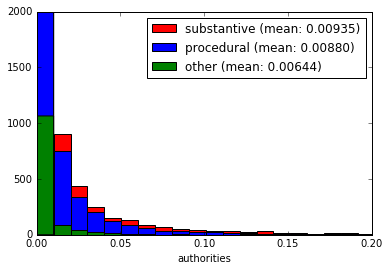

In [218]:

metric = 'authorities'

bins = np.linspace(min(df[metric]), max(df[metric]), 100)

# substantive
plt.hist(df_sub[metric],
         bins=bins,
         color='red',
         label='substantive (mean: %1.5f)' % np.mean(df_sub[metric]))

# procedural
plt.hist(df_pro[metric],
         bins=bins,
         color='blue',
         label='procedural (mean: %1.5f)' % np.mean(df_pro[metric]))

# other
plt.hist(df_oth[metric],
         bins=bins,
         color='green',
         label='other (mean: %1.5f)' % np.mean(df_oth[metric]))

plt.xlim([0, .2])
plt.ylim([0, 2000])

plt.xlabel(metric)
plt.legend(loc='upper right')

In [220]:
# look at propotion of top cases of each type
T = 100

top_cases = df.sort_values(by=metric, ascending=False).iloc[0:T]['type']
top_breakdown = top_cases.value_counts(normalize=True)

# compare to proportion of all cases
all_breakdown = df['type'].value_counts(normalize=True)

diff = top_breakdown - all_breakdown

diff

other               NaN
procedural    -0.169041
substantive    0.214262
Name: type, dtype: float64

# permutation test

Rank cases by _metric_ then look at the proportion of the top T (=100) cases that are substantive.

In [306]:
metric= 'indegree'

df_pro_sub = df[df['type'] != 'other']

T = 100

# observed proportion of top cases that are substantive
obs_top_breakdown = df_pro_sub.\
                    sort_values(by=metric, ascending=False).\
                    iloc[0:T]['type'].\
                    value_counts(normalize=True)
            
obs_prop_sub = obs_top_breakdown['substantive']

In [307]:
R = 1000


perm_prop_sub = [0] * R
for r in range(R):
    
    # randomly select T cases
    perm_indices = np.random.choice(range(df_pro_sub.shape[0]), replace=False, size=T)
    
    # compute the type breakdown of the T cases
    perm_breakdown = df_pro_sub.\
                     iloc[perm_indices]['type'].\
                     value_counts(normalize=True)
    
    # proportion of T cases that are substantive
    perm_prop_sub[r] = perm_breakdown['substantive']
    
perm_prop_sub = np.array(perm_prop_sub)
pval = 1 - np.mean(perm_prop_sub < obs_prop_sub)

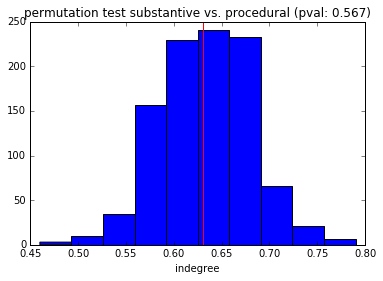

In [308]:
plt.title('permutation test substantive vs. procedural (pval: %1.3f)' % pval)
plt.hist(perm_prop_sub,
         color='blue',
         label='permutation')

plt.axvline(obs_prop_sub,
            color='red',
            label='obs')

plt.xlabel(metric)

## Results

hubs, authorities, u_eigen, d_eign, d_betweeness, u_betweeness are significant (confirming hypothesis)

TODO: recompute u_closeness

# PC plot

In [232]:
df_pro_sub = df[df['type'] != 'other']

U, D, V = get_PCA(df_pro_sub[all_metrics], scale=True)

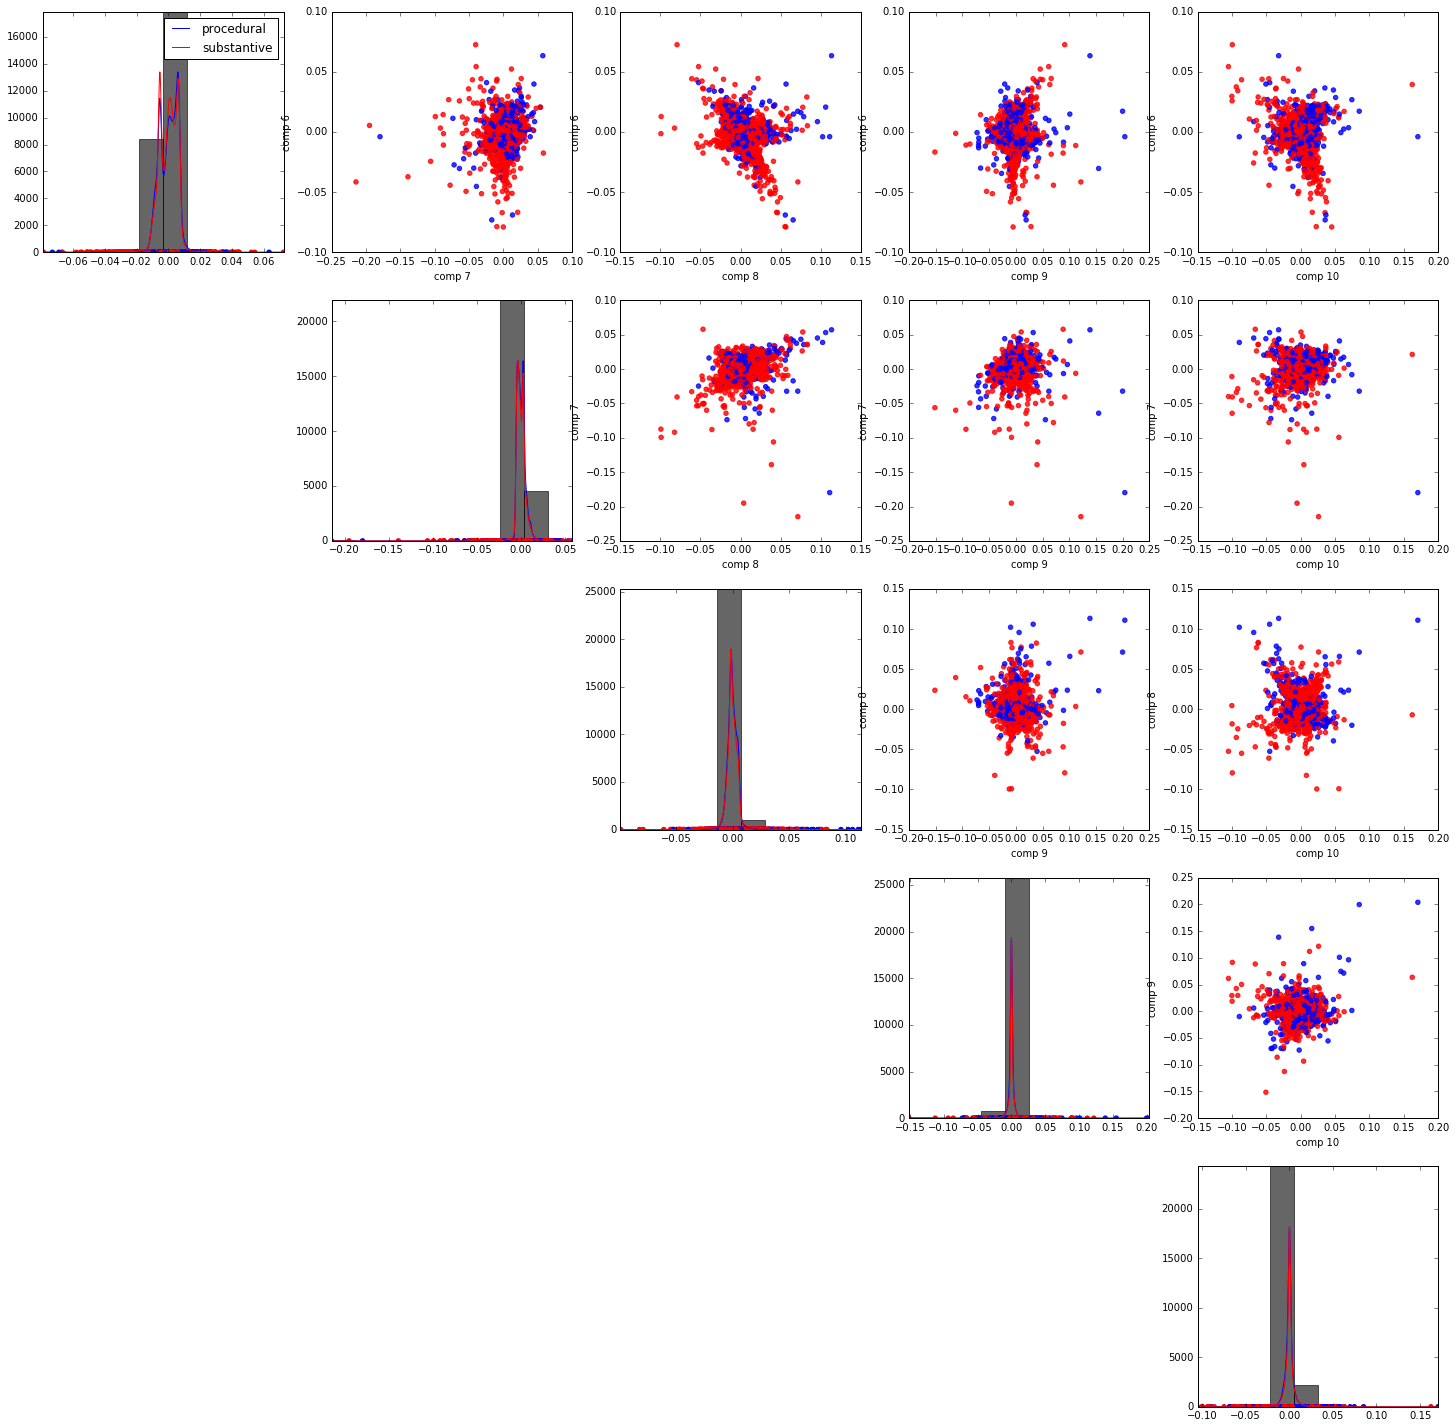

In [238]:
plot_2class_scores(U,
                   classes = df_pro_sub['type'],
                   start=6,
                   n_comp=5)